# Table of Contents
 <p><div class="lev1 toc-item"><a href="#An-example-of-a-small-Single-Player-simulation" data-toc-modified-id="An-example-of-a-small-Single-Player-simulation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>An example of a small Single-Player simulation</a></div><div class="lev2 toc-item"><a href="#Creating-the-problem" data-toc-modified-id="Creating-the-problem-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating the problem</a></div><div class="lev3 toc-item"><a href="#Parameters-for-the-simulation" data-toc-modified-id="Parameters-for-the-simulation-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Parameters for the simulation</a></div><div class="lev3 toc-item"><a href="#Some-MAB-problem-with-Bernoulli-arms" data-toc-modified-id="Some-MAB-problem-with-Bernoulli-arms-112"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Some MAB problem with Bernoulli arms</a></div><div class="lev3 toc-item"><a href="#Some-RL-algorithms" data-toc-modified-id="Some-RL-algorithms-113"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Some RL algorithms</a></div><div class="lev2 toc-item"><a href="#Creating-the-Evaluator-object" data-toc-modified-id="Creating-the-Evaluator-object-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Creating the <code>Evaluator</code> object</a></div><div class="lev2 toc-item"><a href="#Solving-the-problem" data-toc-modified-id="Solving-the-problem-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Solving the problem</a></div><div class="lev2 toc-item"><a href="#Plotting-the-results" data-toc-modified-id="Plotting-the-results-14"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Plotting the results</a></div><div class="lev3 toc-item"><a href="#First-problem" data-toc-modified-id="First-problem-141"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>First problem</a></div><div class="lev3 toc-item"><a href="#Second-problem" data-toc-modified-id="Second-problem-142"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Second problem</a></div><div class="lev3 toc-item"><a href="#Third-problem" data-toc-modified-id="Third-problem-143"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Third problem</a></div>

---
# An example of a small Single-Player simulation

First, be sure to be in the main folder, and import `Evaluator` from `Environment` package:

In [1]:
from sys import path
path.insert(0, '..')

In [2]:
# Local imports
from Environment import Evaluator, tqdm

 - Setting dpi of all figures to 110 ...
 - Setting 'figsize' of all figures to (19.8, 10.8) ...
Info: Using the Jupyter notebook version of the tqdm() decorator, tqdm_notebook() ...


We also need arms, for instance `Bernoulli`-distributed arm:

In [3]:
# Import arms
from Arms import makeMeans, Bernoulli

Info: numba.jit seems to be available.


And finally we need some single-player Reinforcement Learning algorithms:

In [4]:
# Import algorithms
from Policies import *

Info: numba.jit seems to be available.


For instance, this imported the `UCB` algorithm:

In [5]:
help(UCBalpha)

Help on class UCBalpha in module Policies.UCBalpha:

class UCBalpha(Policies.UCB.UCB)
 |  The UCB1 (UCB-alpha) index policy, modified to take a random permutation order for the initial exploration of each arm (reduce collisions in the multi-players setting).
 |  Reference: [Auer et al. 02].
 |  
 |  Method resolution order:
 |      UCBalpha
 |      Policies.UCB.UCB
 |      Policies.IndexPolicy.IndexPolicy
 |      Policies.BasePolicy.BasePolicy
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, nbArms, alpha=4, lower=0.0, amplitude=1.0)
 |      New generic index policy.
 |      
 |      - nbArms: the number of arms,
 |      - lower, amplitude: lower value and known amplitude of the rewards.
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  computeIndex(self, arm)
 |      Compute the current index of arm 'arm'.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Policies.IndexPolicy.IndexPolicy:
 |

---
## Creating the problem

### Parameters for the simulation
- $T = 10000$ is the time horizon,
- $N = 10$ is the number of repetitions,
- `N_JOBS = 4` is the number of cores used to parallelize the code.

In [6]:
HORIZON = 10000
REPETITIONS = 10
N_JOBS = 4

### Some MAB problem with Bernoulli arms
We consider in this example $3$ problems, with `Bernoulli` arms, of different means.

In [7]:
ENVIRONMENTS = [  # 1)  Bernoulli arms
        {   # A very easy problem, but it is used in a lot of articles
            "arm_type": Bernoulli,
            "params": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        },
        {   # An other problem, best arm = last, with three groups: very bad arms (0.01, 0.02), middle arms (0.3 - 0.6) and very good arms (0.78, 0.8, 0.82)
            "arm_type": Bernoulli,
            "params": [0.01, 0.02, 0.3, 0.4, 0.5, 0.6, 0.795, 0.8, 0.805]
        },
        {   # A very hard problem, as used in [Cappé et al, 2012]
            "arm_type": Bernoulli,
            "params": [0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.05, 0.05, 0.1]
        },
    ]

### Some RL algorithms
We compare Thompson Sampling against $\mathrm{UCB}_1$, and $\mathrm{kl}-\mathrm{UCB}$.

In [8]:
POLICIES = [
        # --- UCB1 algorithm
        {
            "archtype": UCBalpha,
            "params": {
                "alpha": 1
            }
        },
        {
            "archtype": UCBalpha,
            "params": {
                "alpha": 0.5  # Smallest theoretically acceptable value
            }
        },
        # --- Thompson algorithm
        {
            "archtype": Thompson,
            "params": {}
        },
        # --- KL algorithms, here only klUCB
        {
            "archtype": klUCB,
            "params": {}
        },
        # --- BayesUCB algorithm
        {
            "archtype": BayesUCB,
            "params": {}
        },
    ]

Complete configuration for the problem:

In [9]:
configuration = {
    # --- Duration of the experiment
    "horizon": HORIZON,
    # --- Number of repetition of the experiment (to have an average)
    "repetitions": REPETITIONS,
    # --- Parameters for the use of joblib.Parallel
    "n_jobs": N_JOBS,    # = nb of CPU cores
    "verbosity": 6,      # Max joblib verbosity
    # --- Arms
    "environment": ENVIRONMENTS,
    # --- Algorithms
    "policies": POLICIES,
}
configuration

{'environment': [{'arm_type': Arms.Bernoulli.Bernoulli,
   'params': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
  {'arm_type': Arms.Bernoulli.Bernoulli,
   'params': [0.01, 0.02, 0.3, 0.4, 0.5, 0.6, 0.795, 0.8, 0.805]},
  {'arm_type': Arms.Bernoulli.Bernoulli,
   'params': [0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.05, 0.05, 0.1]}],
 'horizon': 10000,
 'n_jobs': 4,
 'policies': [{'archtype': Policies.UCBalpha.UCBalpha, 'params': {'alpha': 1}},
  {'archtype': Policies.UCBalpha.UCBalpha, 'params': {'alpha': 0.5}},
  {'archtype': Policies.Thompson.Thompson, 'params': {}},
  {'archtype': Policies.klUCB.klUCB, 'params': {}},
  {'archtype': Policies.BayesUCB.BayesUCB, 'params': {}}],
 'repetitions': 10,
 'verbosity': 6}

---
## Creating the `Evaluator` object

In [10]:
evaluation = Evaluator(configuration)

Number of policies in this comparison: 5
Time horizon: 10000
Number of repetitions: 10
Sampling rate DELTA_T_SAVE: 1
Creating a new MAB problem ...
  Reading arms of this MAB problem from a dictionnary 'configuration' = {'params': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 'arm_type': <class 'Arms.Bernoulli.Bernoulli'>} ...
 - with 'arm_type' = <class 'Arms.Bernoulli.Bernoulli'>
 - with 'params' = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
 - with 'arms' = [B(0.1), B(0.2), B(0.3), B(0.4), B(0.5), B(0.6), B(0.7), B(0.8), B(0.9)]
 - with 'nbArms' = 9
 - with 'maxArm' = 0.9
 - with 'minArm' = 0.1

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 7.52 ... 
 - a Optimal Arm Identification factor H_OI(mu) = 48.89% ...
Creating a new MAB problem ...
  Reading arms of this MAB problem from a dictionnary 'configuration' = {'params': [0.01, 0.02, 0.3, 0.4, 0.5, 0.6, 0.795, 0.8, 0.805], 'arm_type': <class 'Arms.Bernoulli.Bernoulli'>} ...
 - with 'arm_type' = <class '

##  Solving the problem
Now we can simulate all the $3$ environments. That part can take some time.

In [16]:
for envId, env in tqdm(enumerate(evaluation.envs), desc="Problems"):
    # Evaluate just that env
    evaluation.startOneEnv(envId, env)


Evaluating environment: <MAB{'nbArms': 9, 'minArm': 0.10000000000000001, 'maxArm': 0.90000000000000002, 'arms': [B(0.1), B(0.2), B(0.3), B(0.4), B(0.5), B(0.6), B(0.7), B(0.8), B(0.9)]}>
- Adding policy #1 = {'params': {'alpha': 1}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][0]' = {'params': {'alpha': 1}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
- Adding policy #2 = {'params': {'alpha': 0.5}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][1]' = {'params': {'alpha': 0.5}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
- Adding policy #3 = {'params': {}, 'archtype': <class 'Policies.Thompson.Thompson'>} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][2]' = {'params': {}, 'archtype': <class 'Policies.Thompson.Thompson'>} ...
- Adding policy #4 = {'params': {}, 'archtype': <class 'Policies.klUCB.klUCB'>} .

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.9s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.6s finished



- Evaluating policy #2/5: UCB($\alpha=0.5$) ...

Estimated order by the policy UCB($\alpha=0.5$) after 10000 steps: [0 1 3 2 5 4 6 7 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 90.12% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 99.92% (relative success)...
  ==> Spearman    distance from optimal ordering: 100.00% (relative success)...
  ==> Gestalt     distance from optimal ordering: 77.78% (relative success)...
  ==> Mean distance from optimal ordering: 91.95% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.0s remaining:    0.9s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.7s finished



- Evaluating policy #3/5: Thompson ...

Estimated order by the policy Thompson after 10000 steps: [1 3 0 4 2 6 5 7 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 75.31% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 99.33% (relative success)...
  ==> Spearman    distance from optimal ordering: 99.75% (relative success)...
  ==> Gestalt     distance from optimal ordering: 66.67% (relative success)...
  ==> Mean distance from optimal ordering: 85.26% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.7s finished



- Evaluating policy #4/5: KL-UCB(Bern) ...

Estimated order by the policy KL-UCB(Bern) after 10000 steps: [2 3 6 0 1 5 4 7 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 60.49% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 93.94% (relative success)...
  ==> Spearman    distance from optimal ordering: 92.31% (relative success)...
  ==> Gestalt     distance from optimal ordering: 55.56% (relative success)...
  ==> Mean distance from optimal ordering: 75.57% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.3s remaining:    1.0s



- Evaluating policy #5/5: BayesUCB ...


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.1s finished



Estimated order by the policy BayesUCB after 10000 steps: [7 5 6 0 3 2 1 4 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 25.93% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 32.33% (relative success)...
  ==> Spearman    distance from optimal ordering: 23.50% (relative success)...
  ==> Gestalt     distance from optimal ordering: 33.33% (relative success)...
  ==> Mean distance from optimal ordering: 28.77% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.6s remaining:    1.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.4s finished



Evaluating environment: <MAB{'nbArms': 9, 'minArm': 0.01, 'maxArm': 0.80500000000000005, 'arms': [B(0.01), B(0.02), B(0.3), B(0.4), B(0.5), B(0.6), B(0.795), B(0.8), B(0.805)]}>
- Adding policy #1 = {'params': {'alpha': 1}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][0]' = {'params': {'alpha': 1}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
- Adding policy #2 = {'params': {'alpha': 0.5}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][1]' = {'params': {'alpha': 0.5}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
- Adding policy #3 = {'params': {}, 'archtype': <class 'Policies.Thompson.Thompson'>} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][2]' = {'params': {}, 'archtype': <class 'Policies.Thompson.Thompson'>} ...
- Adding policy #4 = {'params': {}, 'archtype': <class 'Policies.klUCB.klUCB'>} ...
  Crea

[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.1s remaining:    2.1s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.2s remaining:    0.9s



- Evaluating policy #2/5: UCB($\alpha=0.5$) ...


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.8s finished



Estimated order by the policy UCB($\alpha=0.5$) after 10000 steps: [0 1 2 3 4 5 8 6 7] ...
  ==> Optimal arm identification: 99.38% (relative success)...
  ==> Manhattan   distance from optimal ordering: 90.12% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 99.92% (relative success)...
  ==> Spearman    distance from optimal ordering: 99.99% (relative success)...
  ==> Gestalt     distance from optimal ordering: 88.89% (relative success)...
  ==> Mean distance from optimal ordering: 94.73% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.0s remaining:    0.9s



- Evaluating policy #3/5: Thompson ...


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.6s finished



Estimated order by the policy Thompson after 10000 steps: [0 5 1 2 3 4 7 8 6] ...
  ==> Optimal arm identification: 98.76% (relative success)...
  ==> Manhattan   distance from optimal ordering: 70.37% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 98.77% (relative success)...
  ==> Spearman    distance from optimal ordering: 98.75% (relative success)...
  ==> Gestalt     distance from optimal ordering: 77.78% (relative success)...
  ==> Mean distance from optimal ordering: 86.42% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.6s finished



- Evaluating policy #4/5: KL-UCB(Bern) ...

Estimated order by the policy KL-UCB(Bern) after 10000 steps: [0 1 3 4 2 5 8 6 7] ...
  ==> Optimal arm identification: 99.38% (relative success)...
  ==> Manhattan   distance from optimal ordering: 80.25% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 99.65% (relative success)...
  ==> Spearman    distance from optimal ordering: 99.91% (relative success)...
  ==> Gestalt     distance from optimal ordering: 77.78% (relative success)...
  ==> Mean distance from optimal ordering: 89.39% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.3s remaining:    1.0s



- Evaluating policy #5/5: BayesUCB ...


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.9s finished



Estimated order by the policy BayesUCB after 10000 steps: [0 1 2 3 5 4 7 6 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 90.12% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 99.92% (relative success)...
  ==> Spearman    distance from optimal ordering: 100.00% (relative success)...
  ==> Gestalt     distance from optimal ordering: 77.78% (relative success)...
  ==> Mean distance from optimal ordering: 91.95% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.7s remaining:    1.1s



Evaluating environment: <MAB{'nbArms': 9, 'minArm': 0.01, 'maxArm': 0.10000000000000001, 'arms': [B(0.01), B(0.01), B(0.01), B(0.02), B(0.02), B(0.02), B(0.05), B(0.05), B(0.1)]}>
- Adding policy #1 = {'params': {'alpha': 1}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][0]' = {'params': {'alpha': 1}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
- Adding policy #2 = {'params': {'alpha': 0.5}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][1]' = {'params': {'alpha': 0.5}, 'archtype': <class 'Policies.UCBalpha.UCBalpha'>} ...
- Adding policy #3 = {'params': {}, 'archtype': <class 'Policies.Thompson.Thompson'>} ...
  Creating this policy from a dictionnary 'self.cfg['policies'][2]' = {'params': {}, 'archtype': <class 'Policies.Thompson.Thompson'>} ...
- Adding policy #4 = {'params': {}, 'archtype': <class 'Policies.klUCB.klUCB'>} ...
  Cr

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.5s finished



Estimated order by the policy UCB($\alpha=1$) after 10000 steps: [0 1 4 5 3 7 6 2 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 70.37% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 96.29% (relative success)...
  ==> Spearman    distance from optimal ordering: 95.76% (relative success)...
  ==> Gestalt     distance from optimal ordering: 66.67% (relative success)...
  ==> Mean distance from optimal ordering: 82.27% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.1s remaining:    0.9s



- Evaluating policy #2/5: UCB($\alpha=0.5$) ...


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.8s finished



Estimated order by the policy UCB($\alpha=0.5$) after 10000 steps: [3 0 1 2 4 5 7 6 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 80.25% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 99.65% (relative success)...
  ==> Spearman    distance from optimal ordering: 99.84% (relative success)...
  ==> Gestalt     distance from optimal ordering: 77.78% (relative success)...
  ==> Mean distance from optimal ordering: 89.38% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.0s remaining:    0.9s



- Evaluating policy #3/5: Thompson ...


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.6s finished



Estimated order by the policy Thompson after 10000 steps: [3 5 2 6 4 1 0 7 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 50.62% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 46.84% (relative success)...
  ==> Spearman    distance from optimal ordering: 54.00% (relative success)...
  ==> Gestalt     distance from optimal ordering: 55.56% (relative success)...
  ==> Mean distance from optimal ordering: 51.75% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.6s finished



- Evaluating policy #4/5: KL-UCB(Bern) ...

Estimated order by the policy KL-UCB(Bern) after 10000 steps: [0 6 2 3 1 7 4 5 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 65.43% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 93.94% (relative success)...
  ==> Spearman    distance from optimal ordering: 92.31% (relative success)...
  ==> Gestalt     distance from optimal ordering: 66.67% (relative success)...
  ==> Mean distance from optimal ordering: 79.59% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    2.2s remaining:    2.2s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    2.4s remaining:    1.0s



- Evaluating policy #5/5: BayesUCB ...


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.5s finished



Estimated order by the policy BayesUCB after 10000 steps: [0 1 5 6 4 7 2 3 8] ...
  ==> Optimal arm identification: 100.00% (relative success)...
  ==> Manhattan   distance from optimal ordering: 60.49% (relative success)...
  ==> Kendell Tau distance from optimal ordering: 90.47% (relative success)...
  ==> Spearman    distance from optimal ordering: 87.50% (relative success)...
  ==> Gestalt     distance from optimal ordering: 66.67% (relative success)...
  ==> Mean distance from optimal ordering: 76.28% (relative success)...


[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    4.3s remaining:    4.3s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    5.0s remaining:    2.1s


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    6.4s finished


## Plotting the results
And finally, visualize them, with the plotting method of a `Evaluator` object:

In [12]:
def plotAll(evaluation, envId):
    evaluation.printFinalRanking(envId)
    evaluation.plotRegrets(envId)
    evaluation.plotRegrets(envId, semilogx=True)
    evaluation.plotRegrets(envId, meanRegret=True)
    evaluation.plotBestArmPulls(envId)

### First problem
$[B(0.1), B(0.2), B(0.3), B(0.4), B(0.5), B(0.6), B(0.7), B(0.8), B(0.9)]$


Final ranking for this environment #0 :
- Policy 'BayesUCB'	was ranked	1 / 5 for this simulation (last regret = 41.8).
- Policy 'UCB($\alpha=0.5$)'	was ranked	2 / 5 for this simulation (last regret = 41.9).
- Policy 'Thompson'	was ranked	3 / 5 for this simulation (last regret = 47.8).
- Policy 'KL-UCB(Bern)'	was ranked	4 / 5 for this simulation (last regret = 48.7).
- Policy 'UCB($\alpha=1$)'	was ranked	5 / 5 for this simulation (last regret = 105.7).

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 7.52 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 48.89% ...


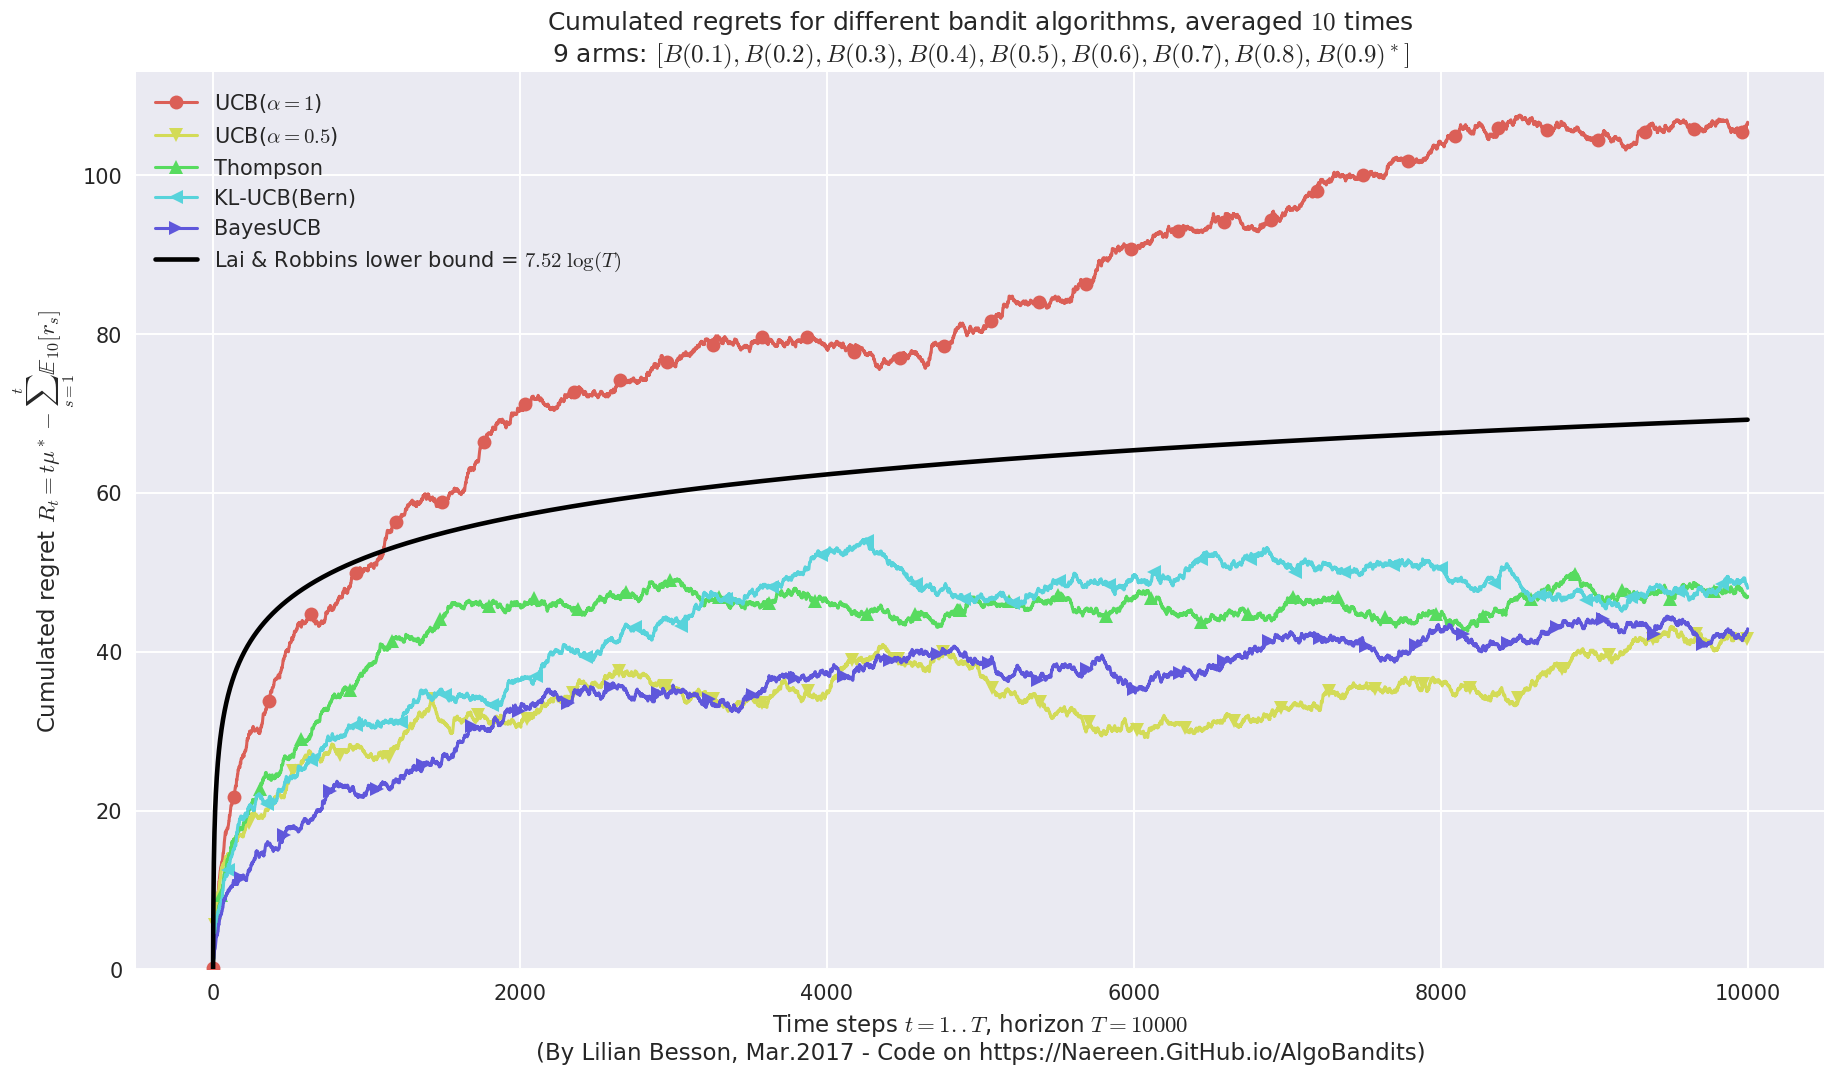


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 7.52 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 48.89% ...


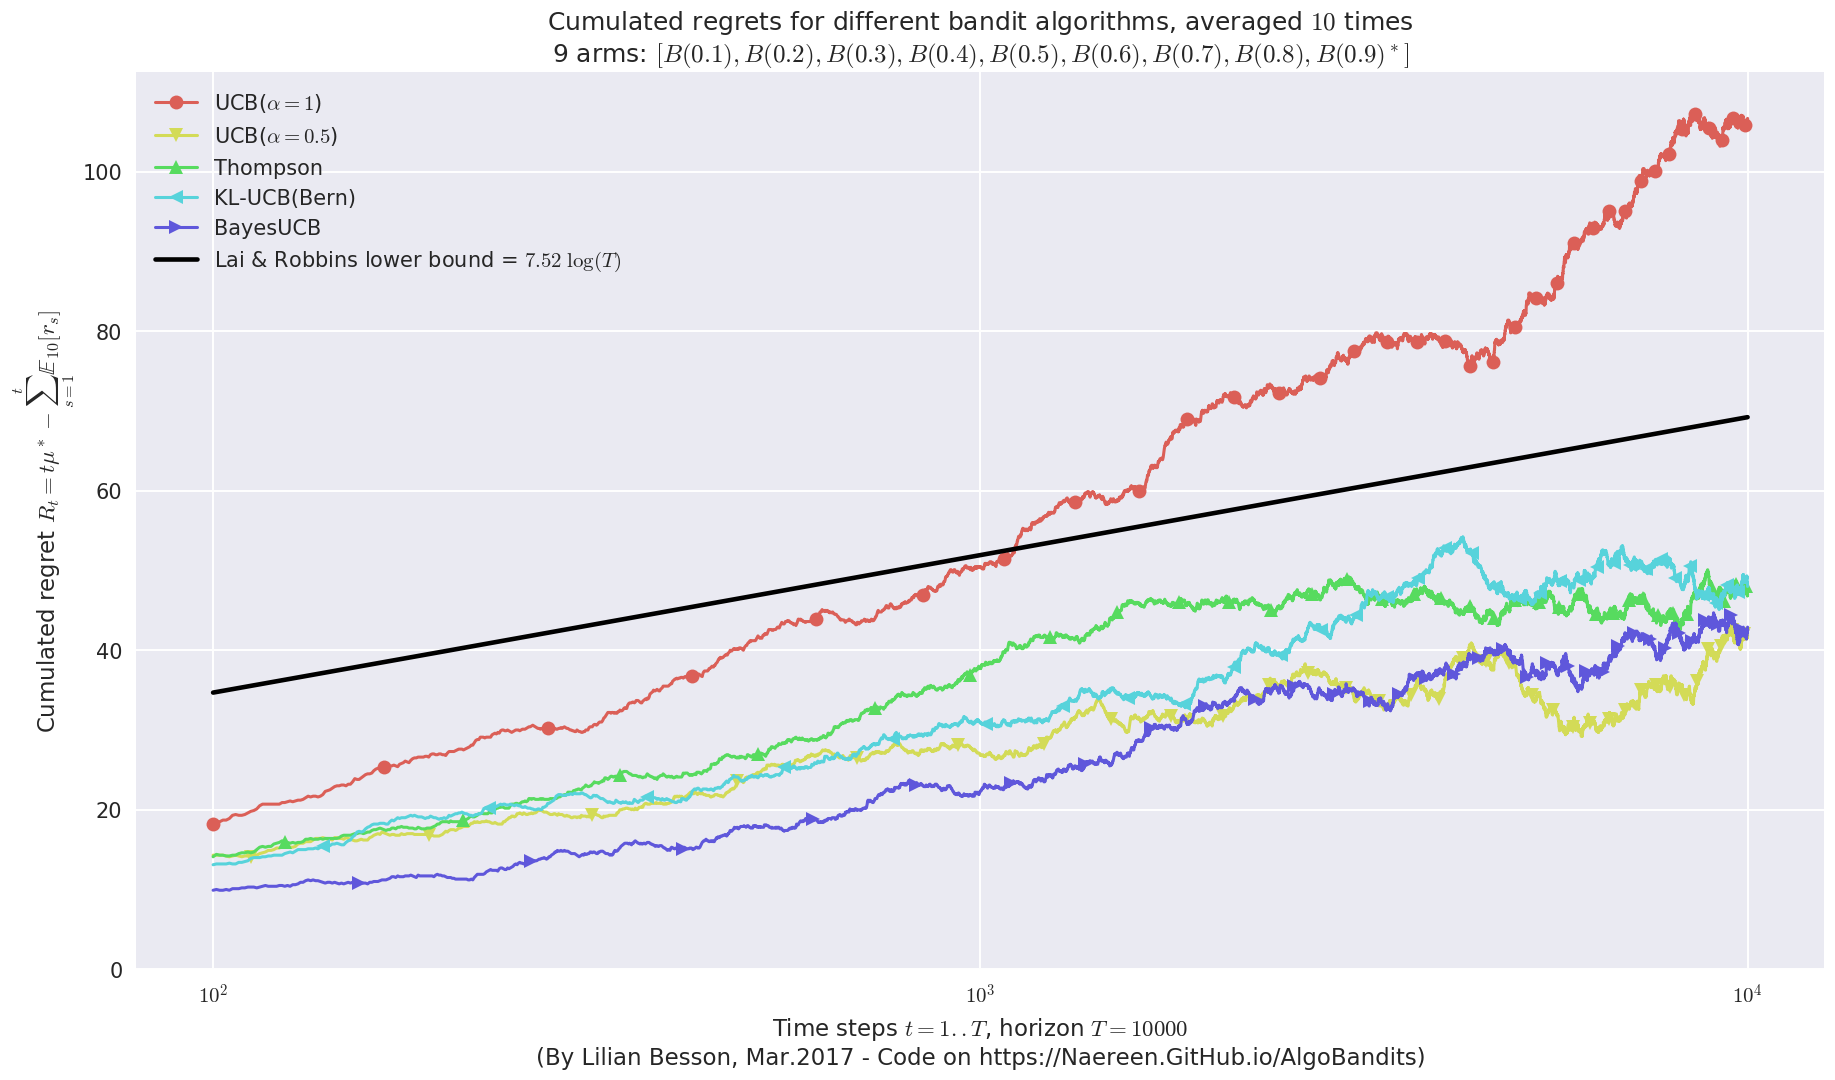


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 7.52 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 48.89% ...


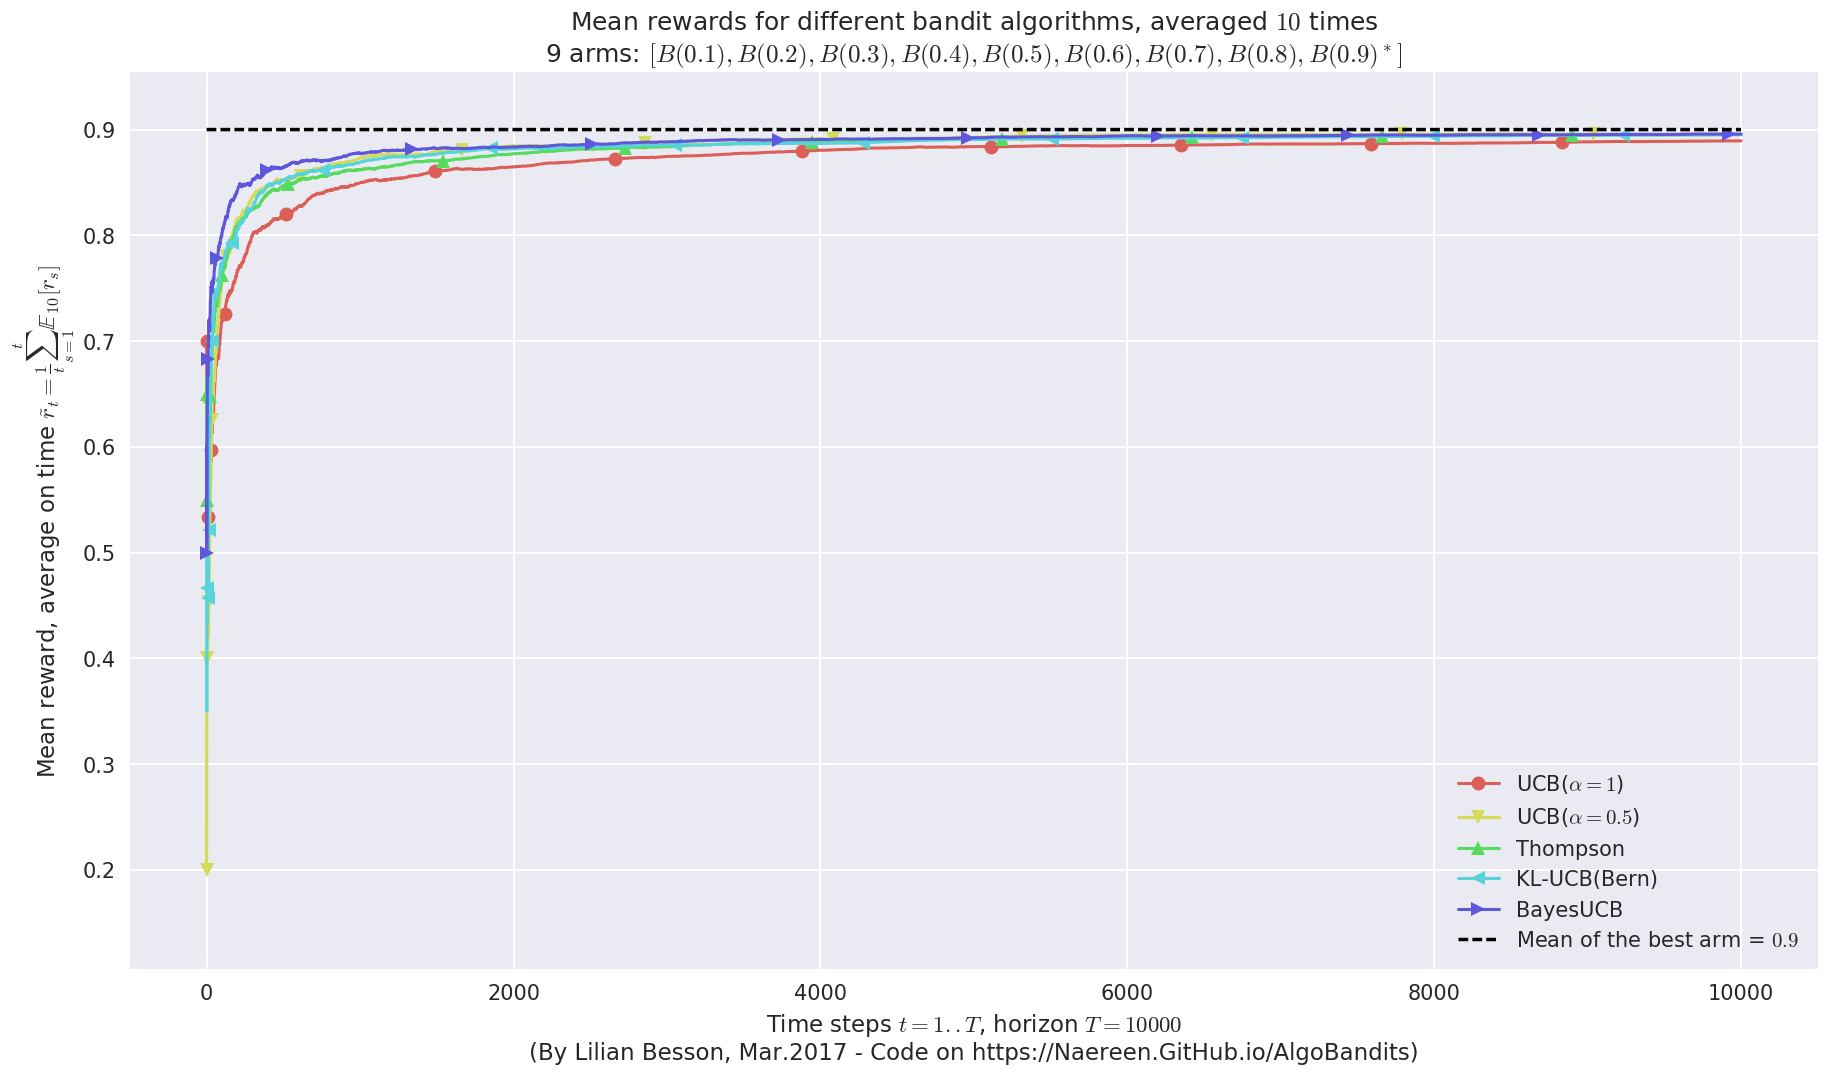

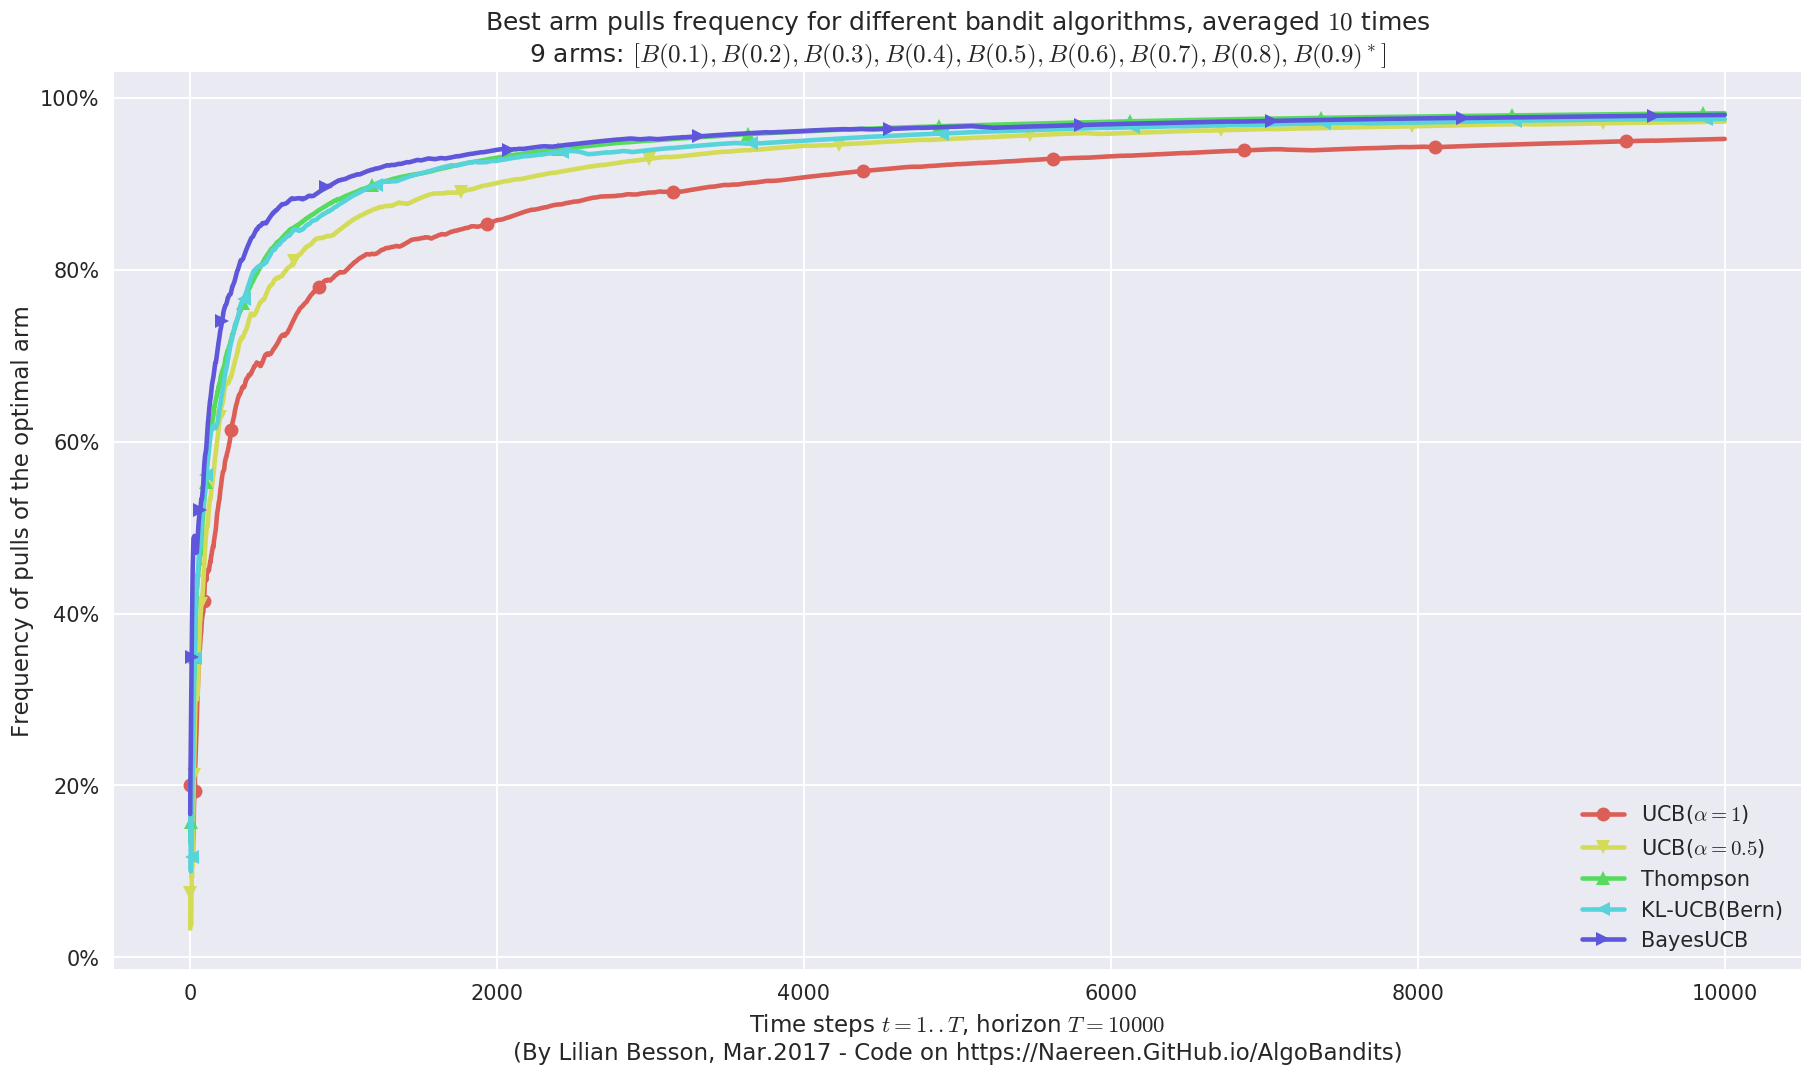

In [13]:
plotAll(evaluation, 0)

### Second problem
$[B(0.01), B(0.02), B(0.3), B(0.4), B(0.5), B(0.6), B(0.795), B(0.8), B(0.805)]$


Final ranking for this environment #1 :
- Policy 'UCB($\alpha=0.5$)'	was ranked	1 / 5 for this simulation (last regret = 65.155).
- Policy 'BayesUCB'	was ranked	2 / 5 for this simulation (last regret = 81.655).
- Policy 'Thompson'	was ranked	3 / 5 for this simulation (last regret = 84.555).
- Policy 'UCB($\alpha=1$)'	was ranked	4 / 5 for this simulation (last regret = 87.455).
- Policy 'KL-UCB(Bern)'	was ranked	5 / 5 for this simulation (last regret = 88.655).

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 101 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 55.39% ...


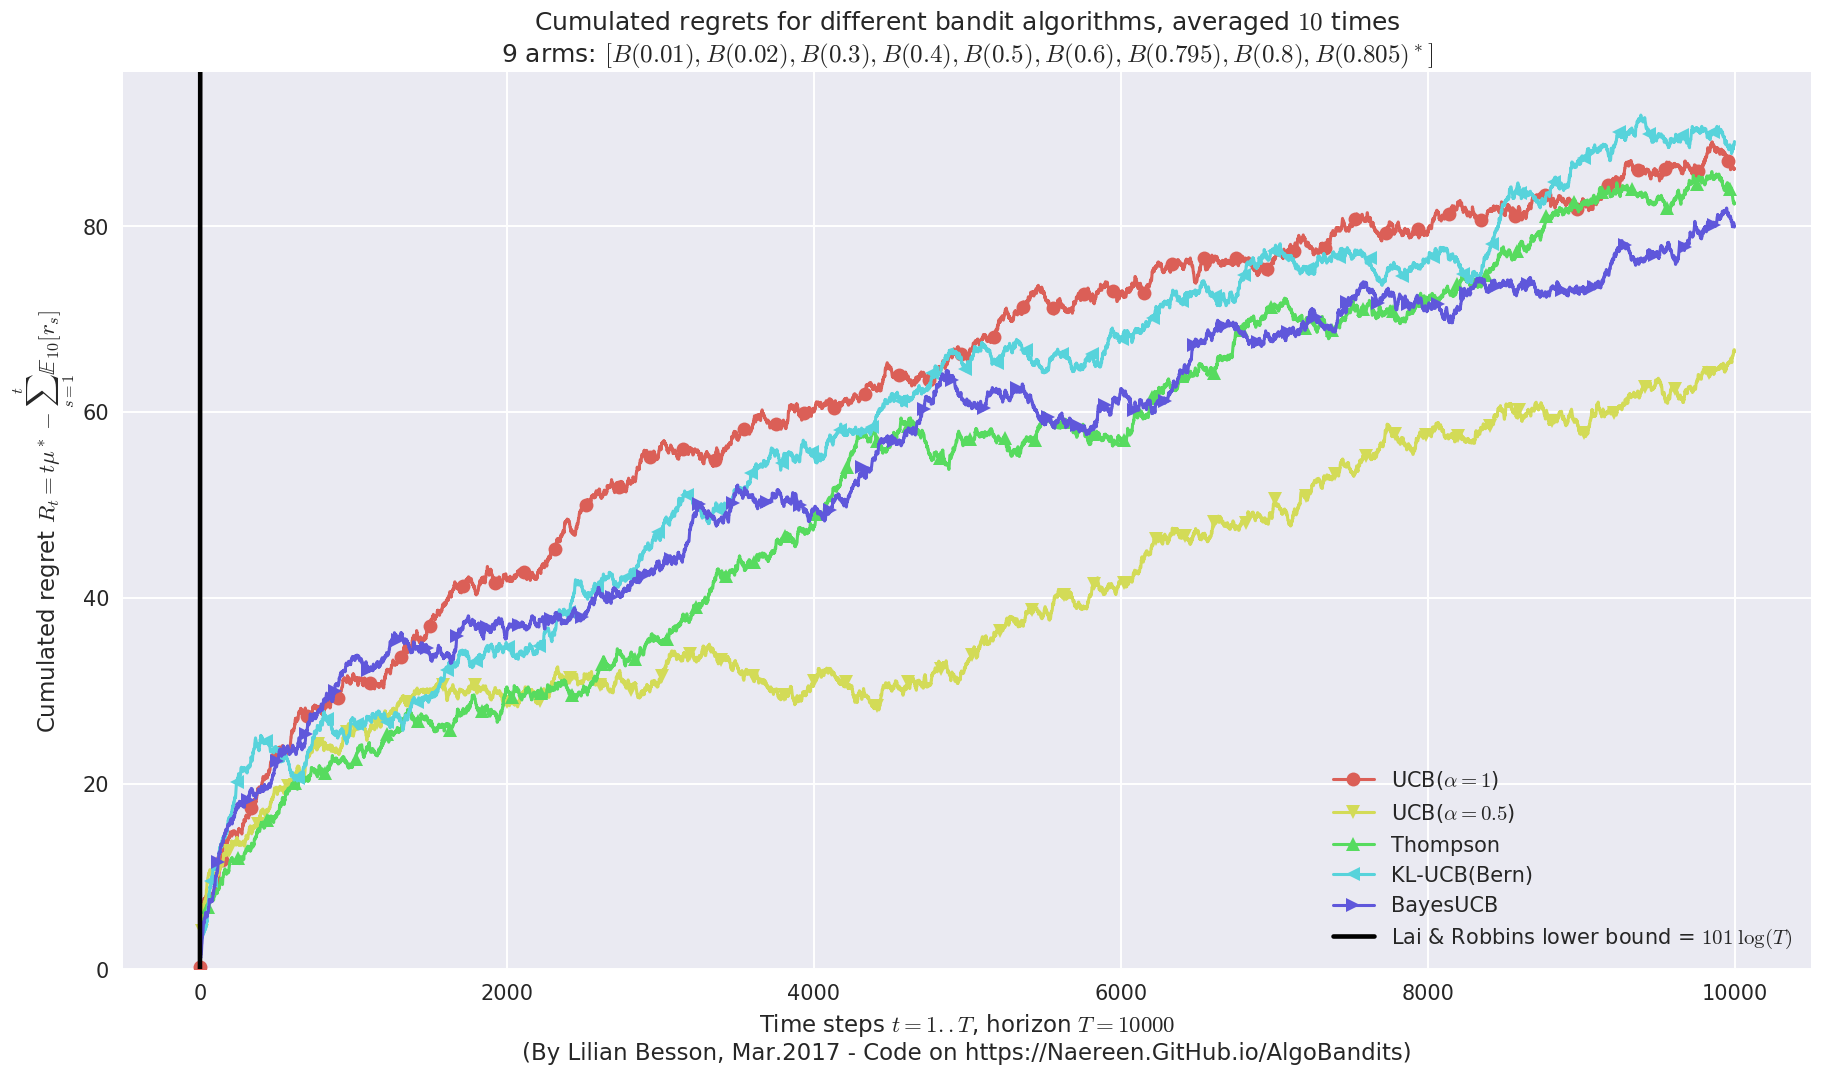


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 101 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 55.39% ...


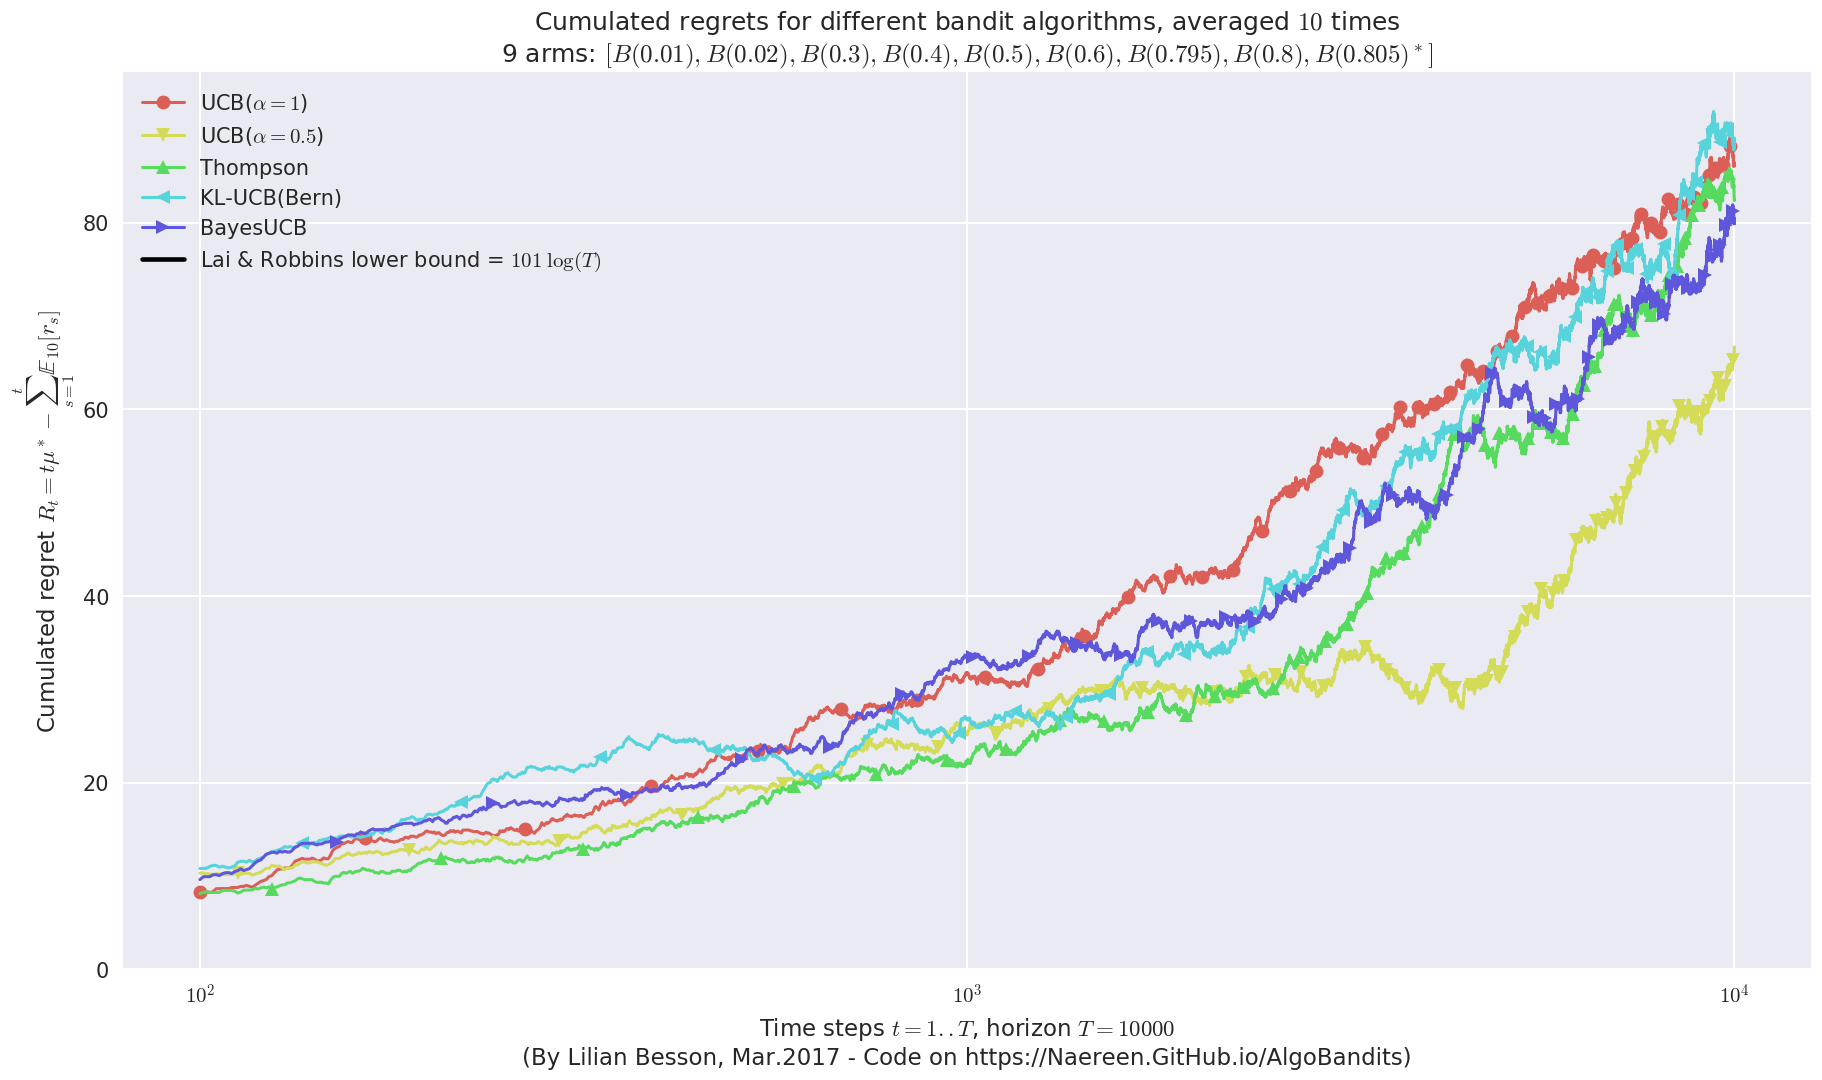


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 101 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 55.39% ...


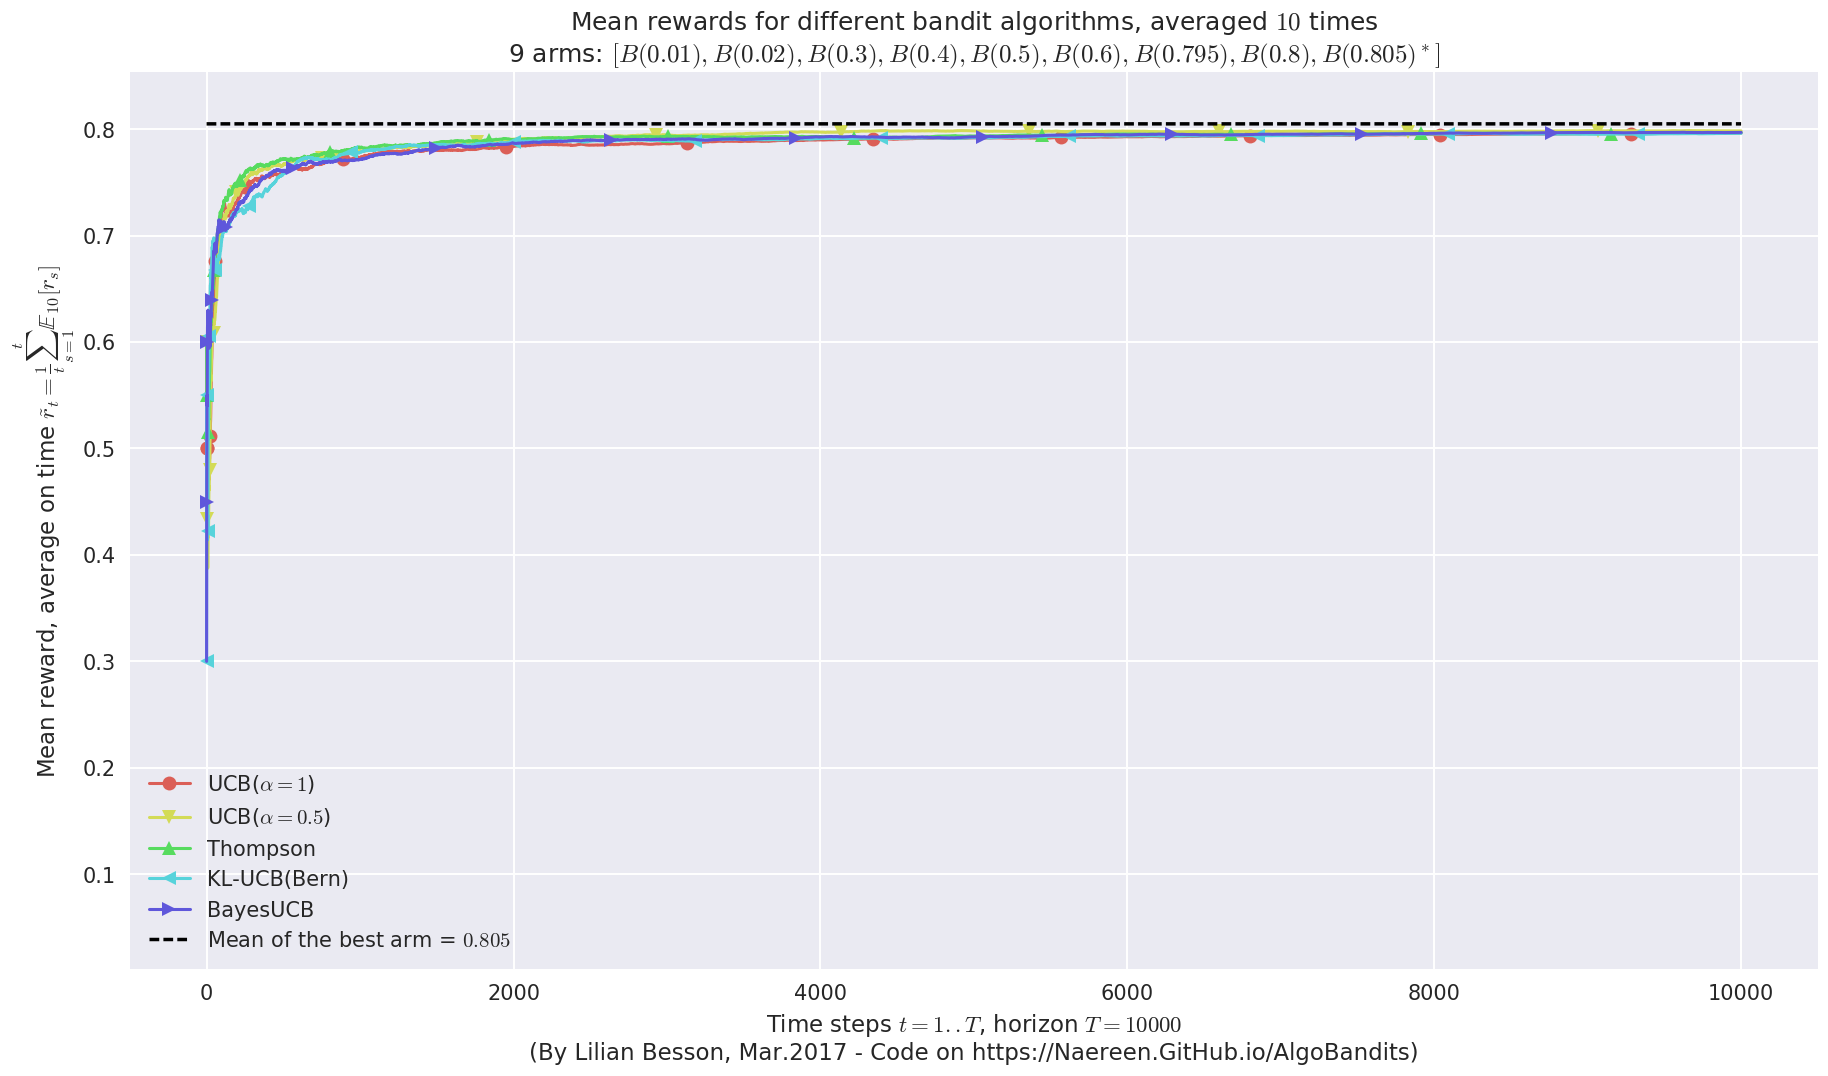

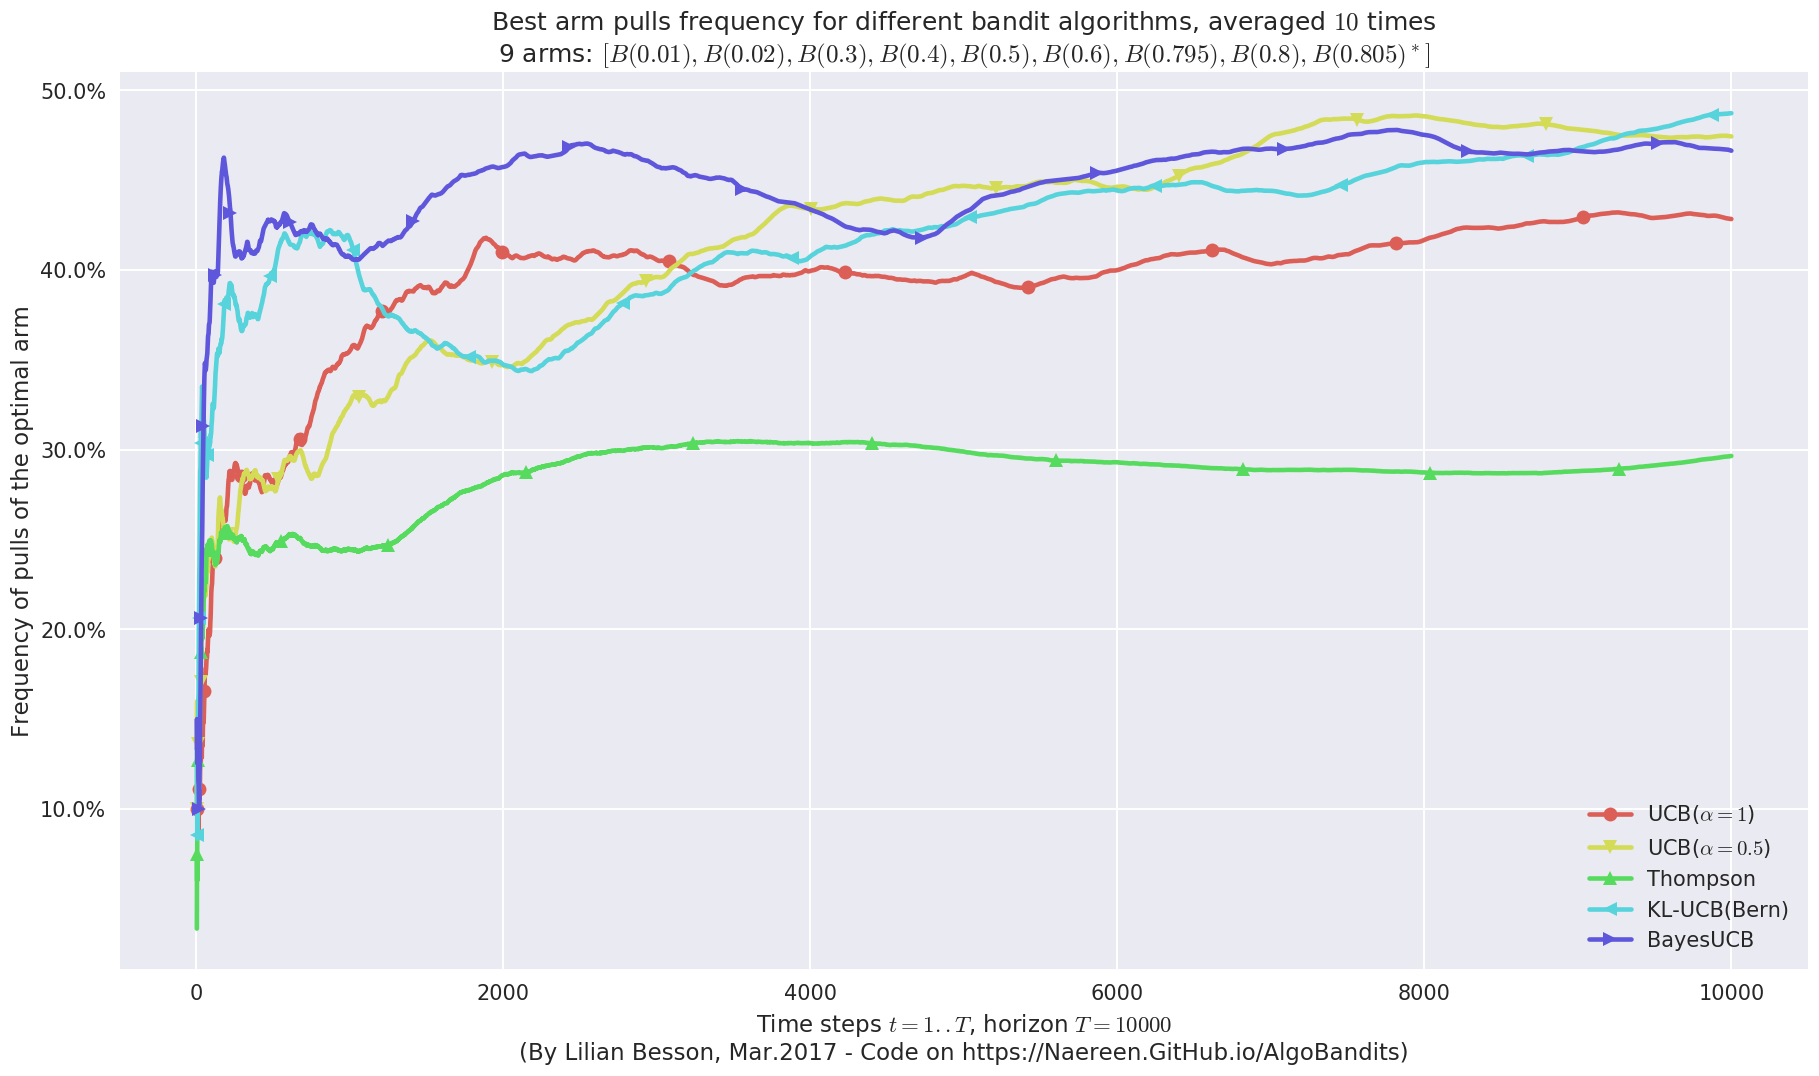

In [14]:
plotAll(evaluation, 1)

### Third problem
$[B(0.01), B(0.01), B(0.01), B(0.02), B(0.02), B(0.02), B(0.05), B(0.05), B(0.1)]$


Final ranking for this environment #2 :
- Policy 'Thompson'	was ranked	1 / 5 for this simulation (last regret = 60.4).
- Policy 'BayesUCB'	was ranked	2 / 5 for this simulation (last regret = 82.9).
- Policy 'KL-UCB(Bern)'	was ranked	3 / 5 for this simulation (last regret = 92.1).
- Policy 'UCB($\alpha=0.5$)'	was ranked	4 / 5 for this simulation (last regret = 144.1).
- Policy 'UCB($\alpha=1$)'	was ranked	5 / 5 for this simulation (last regret = 253.7).

This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 14.5 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 82.11% ...


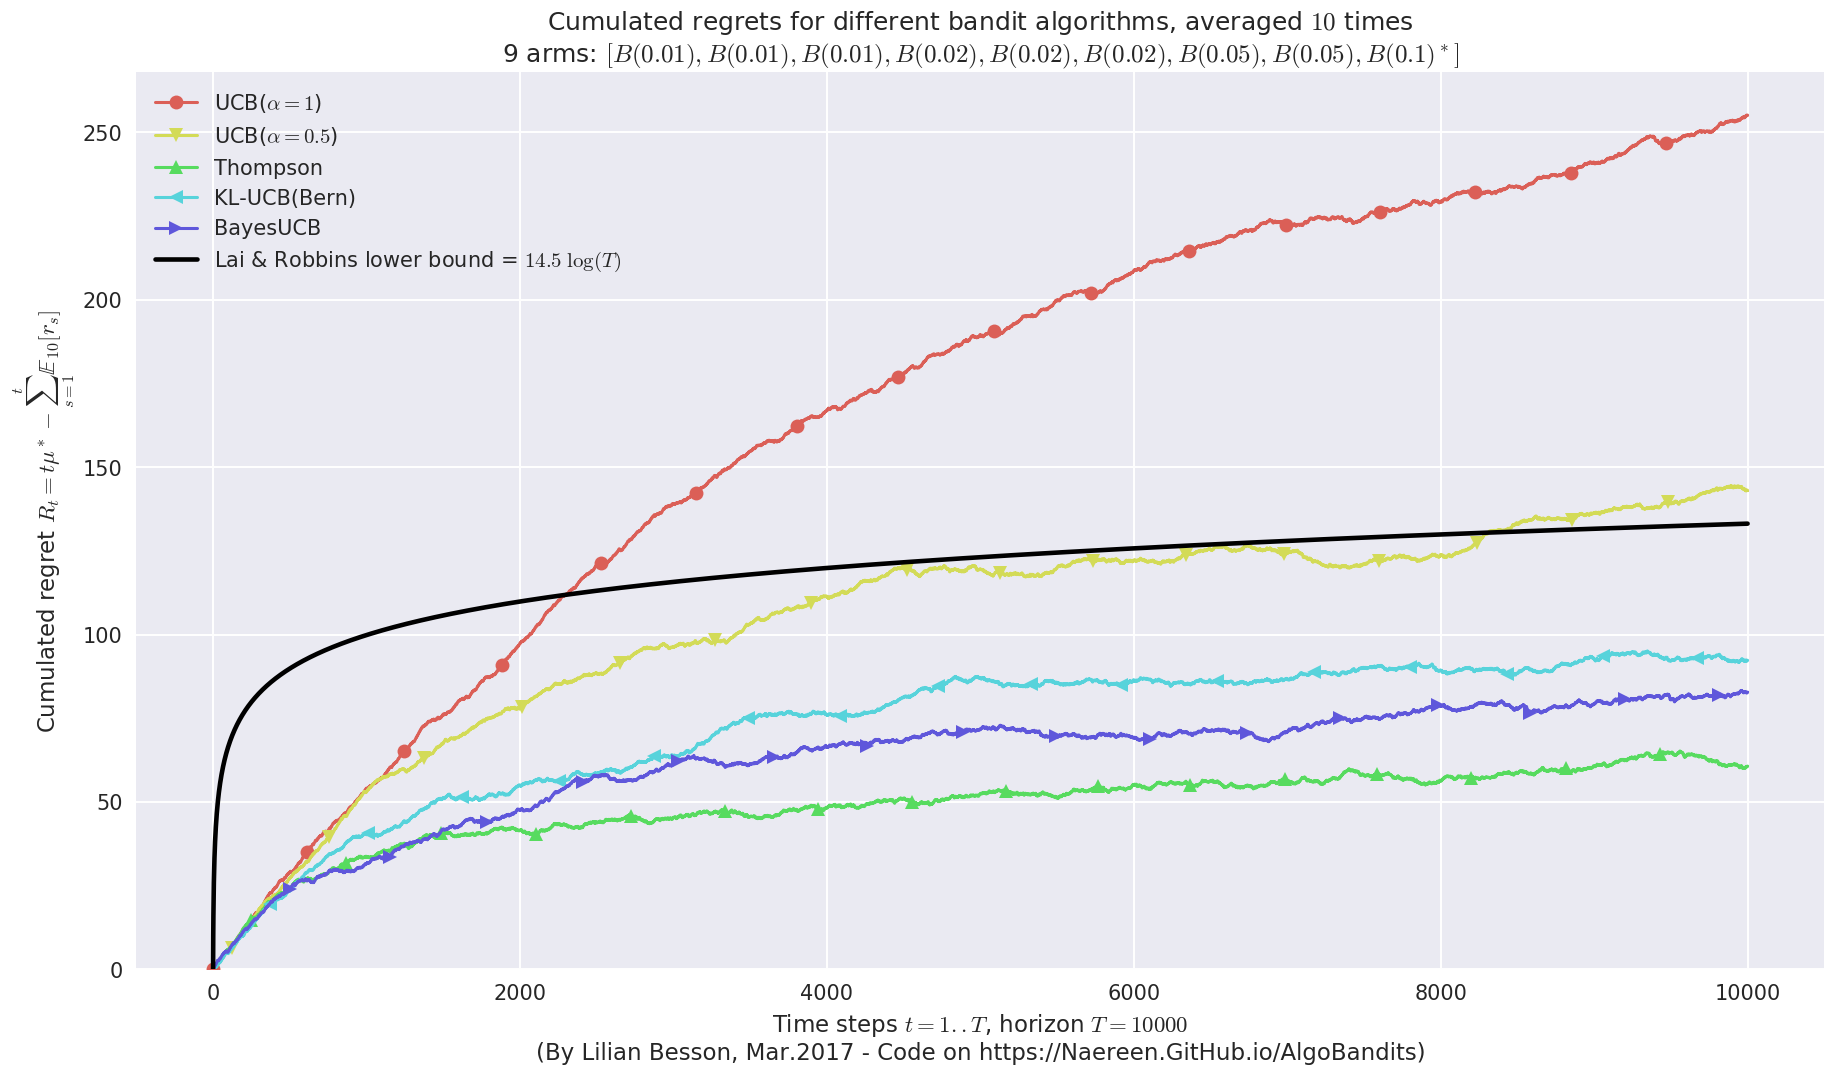


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 14.5 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 82.11% ...


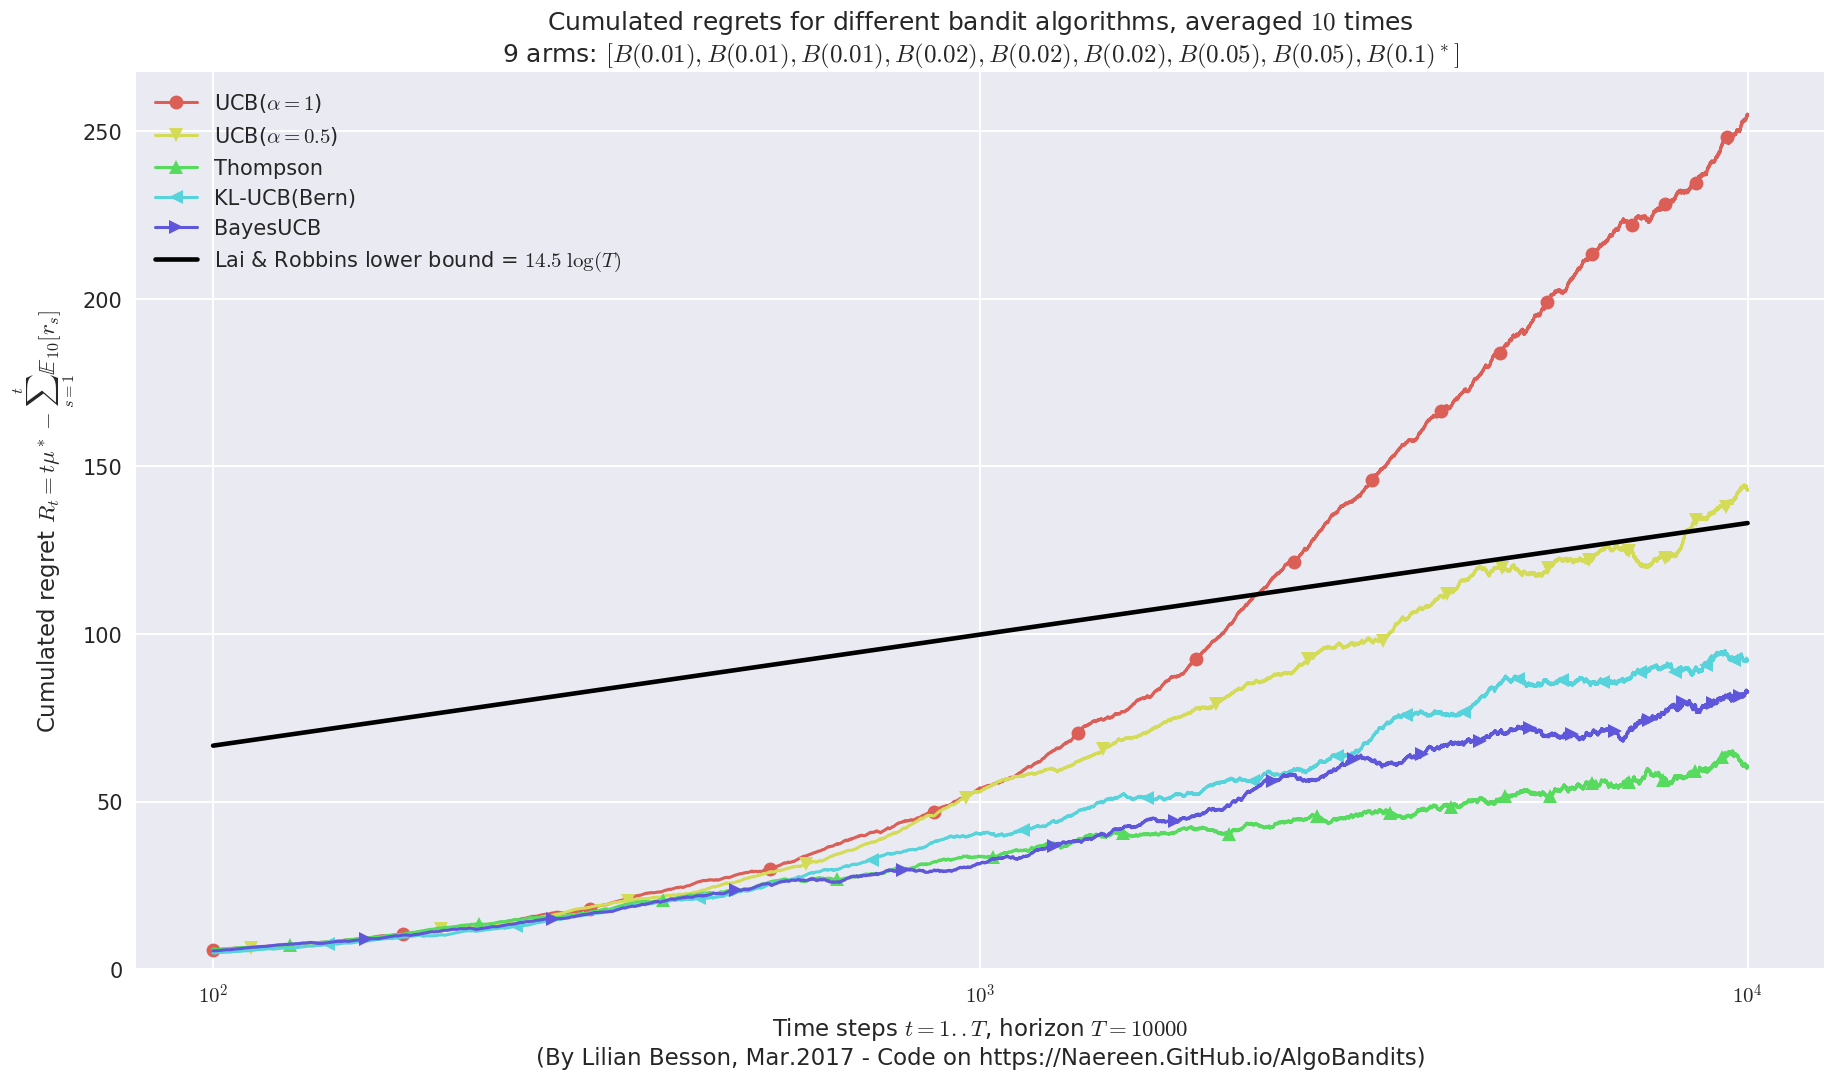


This MAB problem has: 
 - a [Lai & Robbins] complexity constant C(mu) = 14.5 for 1-player problem... 
 - a Optimal Arm Identification factor H_OI(mu) = 82.11% ...


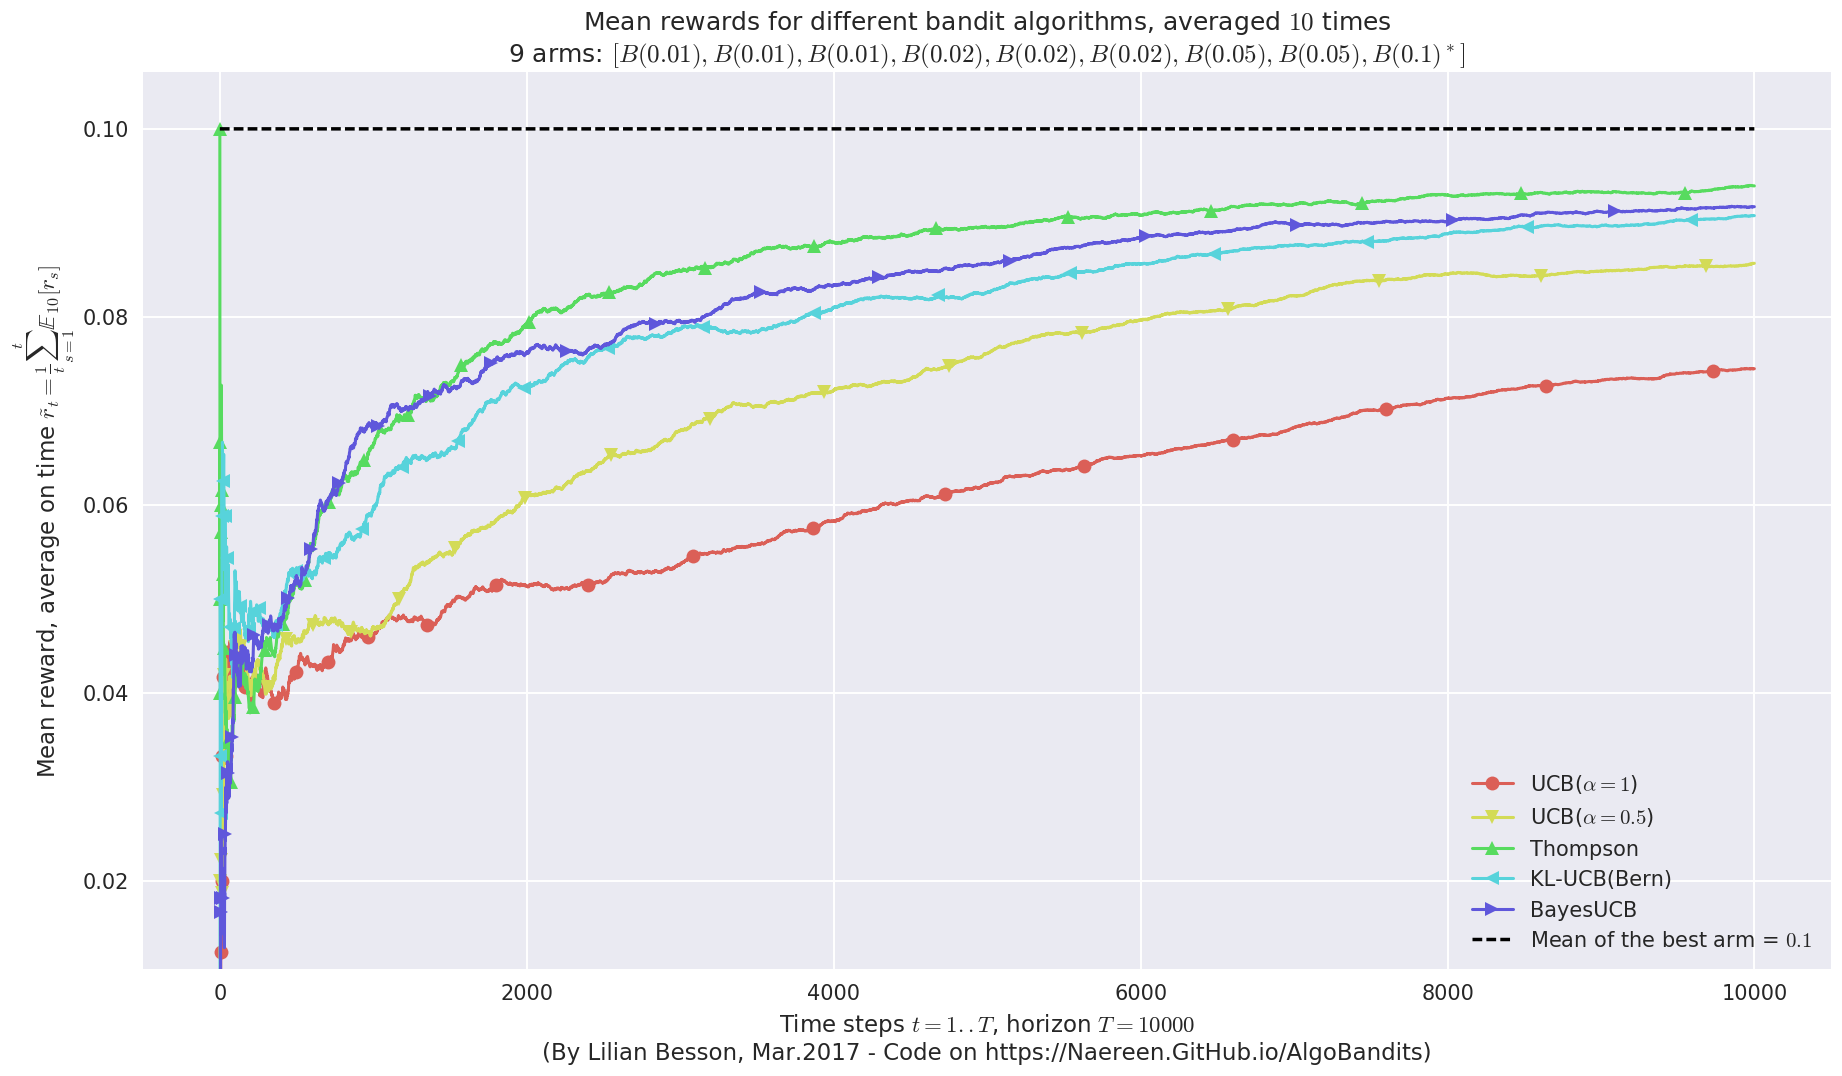

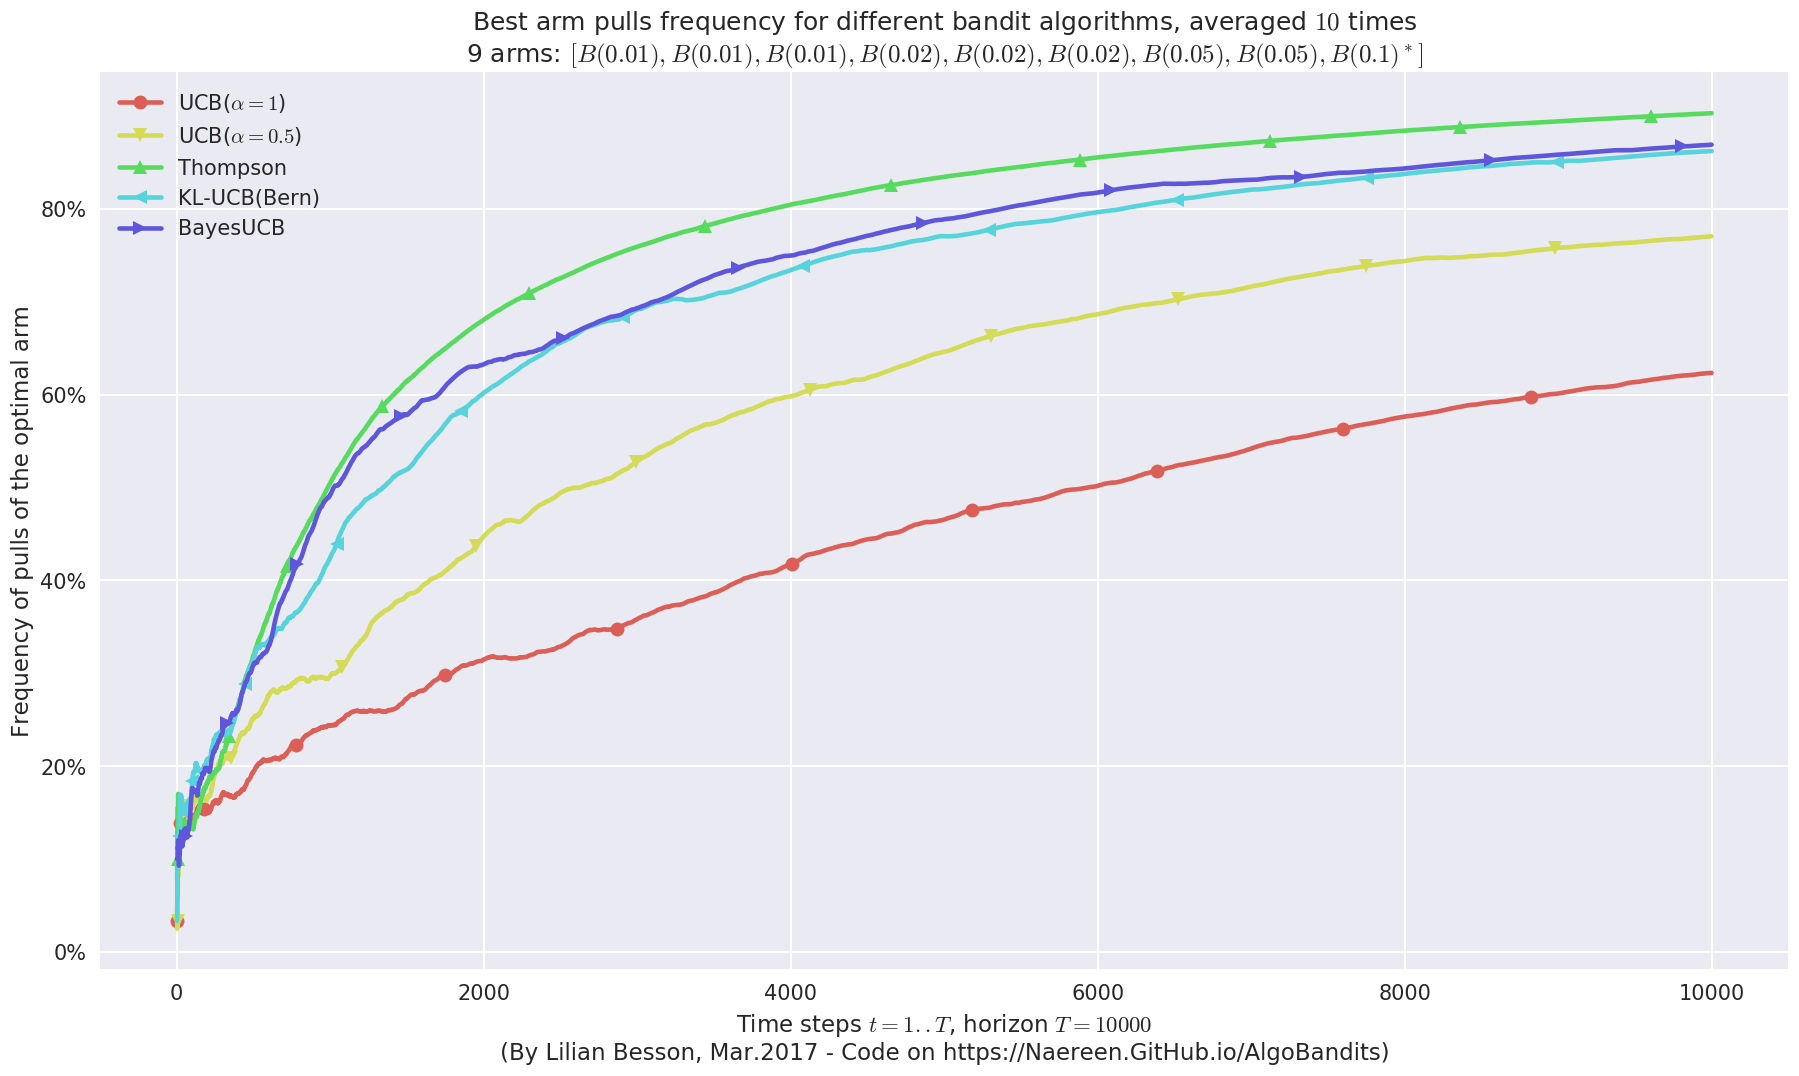

In [15]:
plotAll(evaluation, 2)

---
> That's it for this demo!